# Notebook: Joining Multiple Tables via pandas DataFrames
This Jupyter notebook demonstrates how to join a table that is fragmented across multiple pages.

For a short and appealing presentation of the topic we use the following Python packages beyond PyMuPDF itself. Please note that they are not required to use the table feature itself.

* [matplotlib](https://pypi.org/project/matplotlib/)
* [pandas](https://pypi.org/project/pandas/)

Please check the following list of package installations. These packages ae needed to run this notebook. In case your local configuration is not complete, just un-comment the respective line before using "Run All".

In [1]:
# un-comment any of the following:
#!python -m pip install pymupdf
#!python -m pip install matplotlib
#!python -m pip install pandas
#!python -m pip install numpy

The following function is used for displaying PyMuPDF Pixmaps inline within this notebook. Just technical stuff and not important for understanding the purpose of the document.

In [1]:
"""
Utility function for showing images.

Intended to be imported in Jupyter notebooks to display pixmap images.

Invocation: "show_image(item, title)", where item is a PyMuPDF object
which has a "get_pixmap" method, and title is an optional string.

The function executes "item.get_pixmap(dpi=150)" and show the resulting
image.


Dependencies
------------
numpy, matplotlib, pymupdf
"""


def show_image(item, title=""):
    """Display a pixmap.

    Just to display Pixmap image of "item" - ignore the man behind the curtain.

    Args:
        item: any PyMuPDF object having a "get_pixmap" method.
        title: a string to be used as image title

    Generates an RGB Pixmap from item using a constant DPI and using matplotlib
    to show it inline of the notebook.
    """
    DPI = 150  # use this resolution
    import numpy as np
    import matplotlib.pyplot as plt

    # %matplotlib inline
    pix = item.get_pixmap(dpi=DPI)
    img = np.ndarray([pix.h, pix.w, 3], dtype=np.uint8, buffer=pix.samples_mv)
    plt.figure(dpi=DPI)  # set the figure's DPI
    plt.title(title)  # set title of image
    _ = plt.imshow(img, extent=(0, pix.w * 72 / DPI, pix.h * 72 / DPI, 0))

In [2]:
import pandas as pd  # import pandas
import fitz  # import PyMuPDF
if not hasattr(fitz.Page, "find_tables"):
    raise RuntimeError("This PyMuPDF version does not support the table feature")

# Open Example Document and Show the First Page
This demonstrates the concatenation (merging) of parts of the same table that has b een split across multiple pages.

The file lists national capital cities of the world. From each page, we extract a table fragment, convert it to a pandas DataFrame which we append to a list.

At end of input pages (or when encountering a page with no tables), we concatenate the DataFrames into a final one.

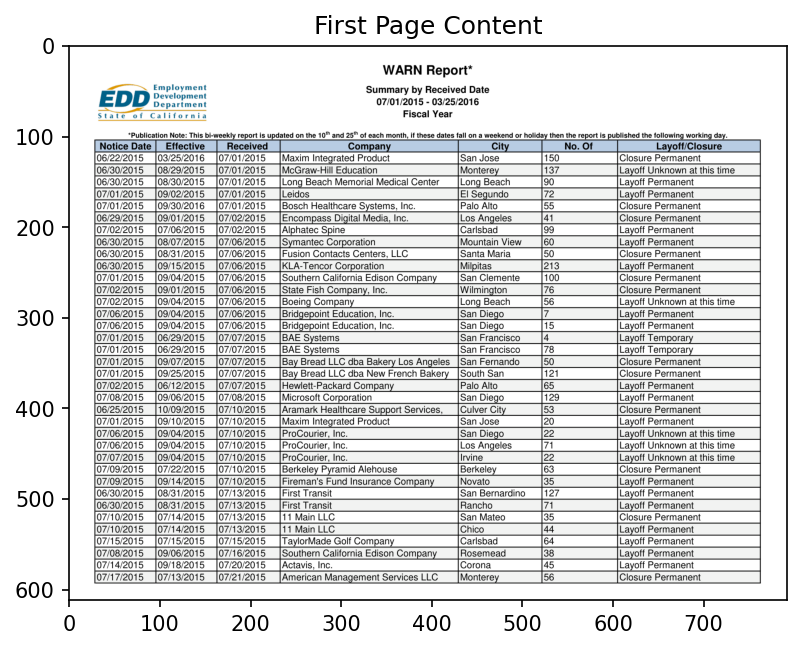

In [3]:
doc = fitz.open("CA Warn Report.pdf")  # open example file
page = doc[0]  # read first page to demo the layout
show_image(page,"First Page Content")

## Extract Table Fragments and Join them in a DataFrame

In [8]:
def solve_non_header_table(df, headers):
    temp_firstrow = pd.DataFrame([list(df.columns)], columns=headers)
    df.columns = headers

    # insert temp_data in to the first row
    df = pd.concat([pd.DataFrame(temp_firstrow, columns=headers), df], ignore_index=True)
    df = df.reset_index(drop=True)
    return df

In [9]:
import pandas as pd # Đảm bảo pandas đã được import

dataframes = []  # List để chứa các DataFrame của từng mảnh bảng
first_page_column_names = None # Để lưu tên cột từ trang đầu tiên

# Mở lại file nếu cần, hoặc đảm bảo biến `doc` đã được khởi tạo từ ô trước
# doc = fitz.open("national-capitals.pdf") 

for page_idx, page in enumerate(doc):  # Lặp qua các trang
    if page_idx > 1:
        break
    tabs = page.find_tables()  # Tìm các bảng trên trang
    
    if not tabs.tables:  # Nếu không tìm thấy bảng nào trên trang này
        # print(f"No tables found on page {page.number}. Stopping.")
        break  # Dừng nếu không còn bảng
        
    current_table_fragment = tabs[0]  # Giả sử mảnh bảng cần lấy là bảng đầu tiên trên trang
    
    if page_idx == 0:
        # Xử lý trang đầu tiên (được cho là có header)
        df_page = current_table_fragment.to_pandas()
        if not df_page.empty:
            first_page_column_names = df_page.columns.tolist()  # Lưu lại tên các cột
            dataframes.append(df_page)
        else:
            print("Warning: Empty table found on the first page. Cannot determine headers.")
            break 
    else:
        # Xử lý các trang tiếp theo (được cho là KHÔNG có header)
        if first_page_column_names:
            # Sử dụng header=None để Pandas không tự suy luận header từ dữ liệu
            # và cung cấp `names` đã lấy từ trang đầu tiên
            df_page = current_table_fragment.to_pandas()
            if not df_page.empty:
                # Kiểm tra xem số cột có khớp không (tùy chọn, nhưng nên có)
                if df_page.shape[1] == len(first_page_column_names):
                    df_page = solve_non_header_table(df=df_page, headers=first_page_column_names)
                    dataframes.append(df_page)
                else:
                    print(f"Warning on page {page.number}: Column count mismatch. "
                          f"Expected {len(first_page_column_names)}, got {df_page.shape[1]}. "
                          "Skipping this page's table fragment.")
            # Nếu df_page rỗng (không có dữ liệu), không cần thêm vào
        else:
            # Điều này không nên xảy ra nếu trang đầu tiên có bảng và header hợp lệ
            print("Error: Column names from the first page were not determined. Stopping.")
            break

# Nối tất cả các DataFrames lại
if dataframes:
    final_df = pd.concat(dataframes, ignore_index=True)
    display(final_df)  # Hiển thị DataFrame kết quả
else:
    print("No dataframes were created to concatenate.")
    final_df = pd.DataFrame() # Hoặc trả về DataFrame rỗng

,Notice Date,Effective,Received,Company,City,No. Of,Layoff/Closure
0,06/22/2015,03/25/2016,07/01/2015,Maxim Integrated Product,San Jose,150,Closure Permanent
1,06/30/2015,08/29/2015,07/01/2015,McGraw-Hill Education,Monterey,137,Layoff Unknown at this time
2,06/30/2015,08/30/2015,07/01/2015,Long Beach Memorial Medical Center,Long Beach,90,Layoff Permanent
3,07/01/2015,09/02/2015,07/01/2015,Leidos,El Segundo,72,Layoff Permanent
4,07/01/2015,09/30/2016,07/01/2015,"Bosch Healthcare Systems, Inc.",Palo Alto,55,Closure Permanent
...,...,...,...,...,...,...,...
74,07/28/2015,09/28/2015,08/03/2015,CR Briggs Corporation,Trona,5,Layoff Permanent
75,07/29/2015,08/03/2015,08/03/2015,Molycorp Minerals LLC,Mountain Pass,474,Layoff Permanent
76,07/30/2015,09/30/2015,08/03/2015,Binder & Binder,Orange,70,Closure Permanent
77,07/31/2015,09/30/2015,08/03/2015,"Driscoll's Strawberry Associates, Inc.",Salinas,38,Closure Permanent


In [25]:
### thực hiện lấy tables ra

pages = [0, 1, 14, 15]
for page_number in pages:
    page = doc[page_number]
    tabs = page.find_tables()
    for tab in tabs.tables:
        df = tab.to_pandas()
        df.to_csv(f"test_table_{page_number}.csv", index=False)

In [10]:
with open("test.txt", "w") as f:
    f.write(final_df.to_string())

In [15]:
def is_new_table(current_headers, new_table, last_page_had_table):
    """
    Kiểm tra xem có phải bảng mới không dựa trên các tiêu chí:
    1. Header khác biệt
    2. Số cột khác biệt (trừ trường hợp dòng tổng kết)
    3. Không có bảng ở trang trước
    """
    if not last_page_had_table:
        return True
        
    if current_headers is None:
        return True
        
    new_df = new_table.to_pandas()
    
    # Nếu số cột khác biệt đáng kể
    if new_df.shape[1] != len(current_headers):
        # Kiểm tra xem có phải dòng tổng kết không
        if new_df.shape[0] == 1 and new_df.shape[1] < len(current_headers):
            return False
        return True
        
    # Kiểm tra header có khác biệt không
    new_headers = new_table.header.names
    if new_headers and new_headers != current_headers:
        return True
        
    return False

def process_tables_in_pdf(doc):
    all_tables = []  # Danh sách chứa tất cả các bảng hoàn chỉnh
    current_fragments = []  # Các mảnh của bảng hiện tại
    current_headers = None
    last_page_had_table = False

    for page_idx, page in enumerate(doc):
        tabs = page.find_tables()
        table_found = bool(tabs.tables)
        
        if table_found:
            current_table = tabs[0]
            
            if is_new_table(current_headers, current_table, last_page_had_table):
                # Hoàn thành bảng trước đó nếu có
                if current_fragments:
                    complete_table = pd.concat(current_fragments, ignore_index=True)
                    all_tables.append(complete_table)
                    current_fragments = []
                
                # Bắt đầu bảng mới
                df_page = current_table.to_pandas()
                current_headers = df_page.columns.tolist()
                current_fragments = [df_page]
            else:
                # Tiếp tục với bảng hiện tại
                df_page = current_table.to_pandas()
                if df_page.shape[1] == len(current_headers):
                    df_page = solve_non_header_table(df=df_page, headers=current_headers)
                    current_fragments.append(df_page)
        
        # Nếu không tìm thấy bảng và đang có fragments, kết thúc bảng hiện tại
        elif current_fragments:
            complete_table = pd.concat(current_fragments, ignore_index=True)
            all_tables.append(complete_table)
            current_fragments = []
            current_headers = None
            
        last_page_had_table = table_found
    
    # Xử lý bảng cuối cùng nếu còn
    if current_fragments:
        complete_table = pd.concat(current_fragments, ignore_index=True)
        all_tables.append(complete_table)
    
    return all_tables

# Sử dụng:
tables = process_tables_in_pdf(doc)
for idx, table in enumerate(tables):
    print(f"\nTable {idx + 1}:")
    print(f"Shape: {table.shape}")
    print("Headers:", table.columns.tolist())
    print(table.head())
    # Lưu vào file nếu cần
    table.to_csv(f"table_{idx + 1}.csv", index=False)


Table 1:
Shape: (36, 7)
Headers: ['Notice Date', 'Effective', 'Received', 'Company', 'City', 'No. Of', 'Layoff/Closure']
  Notice Date   Effective    Received                             Company  \
0  06/22/2015  03/25/2016  07/01/2015            Maxim Integrated Product   
1  06/30/2015  08/29/2015  07/01/2015               McGraw-Hill Education   
2  06/30/2015  08/30/2015  07/01/2015  Long Beach Memorial Medical Center   
3  07/01/2015  09/02/2015  07/01/2015                              Leidos   
4  07/01/2015  09/30/2016  07/01/2015      Bosch Healthcare Systems, Inc.   

         City No. Of               Layoff/Closure  
0    San Jose    150            Closure Permanent  
1    Monterey    137  Layoff Unknown at this time  
2  Long Beach     90             Layoff Permanent  
3  El Segundo     72             Layoff Permanent  
4   Palo Alto     55            Closure Permanent  

Table 2:
Shape: (42, 7)
Headers: ['07/17/2015', '09/18/2015', '07/21/2015', 'Boeing Company', 'Hunting

## Extract Table Fragments and Join them in a List
Joining table fragments without using pandas is not difficult either. We simply join the lists of extracted cell text per page.

Here we also check whether the continuation table has indeed the same column header names.

In [5]:
names0 = None  # column names for comparison purposes
all_extracts = []  # all table rows go here

for page in doc:  # iterate over the pages
    tabs = page.find_tables()  # find tables on page
    if tabs.tables == []:  # a page without table: stop processing
        break
    tab = tabs[0]  # access first table
    header = tab.header  # get its header
    external = header.external  # header outside table body?
    names = header.names  # column names
    if page.number == 0:  # on first page, store away column names
        names0 = names
    elif names != names0:  # not our table anymore
        break
    extract = tab.extract()  # get text for all table cells
    if not external:  # if header contained in table body 
        extract = extract[1:]  # omit repeating header row
    all_extracts.extend(extract)  # append to total list

print(f"The joined table has {len(all_extracts)} rows and {len(names0)} columns.\n")
print(names0)
for i, r in enumerate(all_extracts):
    print(r)
    if i >= 10:
        print("...")
        break


The joined table has 204 rows and 5 columns.

['Country', 'Capital', 'Population', '%', 'Year']
['Afghanistan', 'Kabul', '4601789', '11.5%', '2021']
['Albania', 'Tirana', '557422', '19.5%', '2011']
['Algeria', 'Algiers', '3915811', '8.9%', '2011']
['American Samoa (USA)', 'Pago Pago', '3656', '8.1%', '2010']
['Andorra', 'Andorra la Vella', '22873', '28.9%', '2022']
['Angola', 'Luanda', '2571861', '7.5%', '2020']
['Anguilla (UK)', 'The Valley', '1067', '6.8%', '2011']
['Antigua and Barbuda', "St. John's", '22219', '23.8%', '2011']
['Argentina', 'Buenos Aires', '2891082', '6.4%', '2010']
['Armenia', 'Yerevan', '1096100', '39.3%', '2021']
['Aruba (Netherlands)', 'Oranjestad', '28294', '26.6%', '2010']
...
